<a href="https://colab.research.google.com/github/Veronika2311/compsem/blob/main/Ganeeva_Veronika_hw2_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашнее задание 2. Кластеризация векторного пространства

*Вероника Ганеева, БКЛ181*

In [8]:
import sys
import gensim, logging
 
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [28]:
import urllib
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy as hcluster

In [10]:
pip install wget

In [118]:
import wget
import zipfile

### Модель


Способ загрузки взят из тьюториала А. Кутузова для сайта русвекторес. Модель взята ruscorpora_upos_cbow_300_20_2019 -- НКРЯ, не очень большая, но последняя статистическая именно для НКРЯ и, должно быть, довольно качественная. 

In [12]:
model_url = 'http://vectors.nlpl.eu/repository/11/180.zip'
m = wget.download(model_url)
model_file = model_url.split('/')[-1]
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

2021-04-06 18:39:20,471 : INFO : loading projection weights from <zipfile.ZipExtFile name='model.bin' mode='r' compress_type=deflate>
2021-04-06 18:39:30,829 : INFO : loaded (189193, 300) matrix from <zipfile.ZipExtFile [closed]>


### Векторы из модели

In [21]:
with open('otkryt.txt') as f:
    all_words = f.read().split('\n')
for i, word in enumerate(all_words):
    word = word.split('\t')[0].split('_')[1] + '_NOUN'
    all_words[i] = word

In [117]:
dict_of_nouns = {}
non_vector_words = []
for word in all_words:
    if word in model:
        #print(word)
        dict_of_nouns[word] = model[word]
    else:
        non_vector_words.append(word)
        print('Увы, слова "%s" нет в модели!' % word)

In [88]:
all_vectors_list = []
list_of_words = []
otkryt_vector = model['открыть_VERB']
dict_of_vectors = {}
for word, vector in dict_of_nouns.items():
    word = 'открыть_' + word
    dict_of_vectors[word] = otkryt_vector + vector
    all_vectors_list.append(otkryt_vector + vector)
    list_of_words.append(word)

In [89]:
len(dict_of_nouns)

100

Ура, мы не потеряли слова и все из них нашлись в нашей модели!

### Классификация

In [90]:
word_matrix = np.array(all_vectors_list)

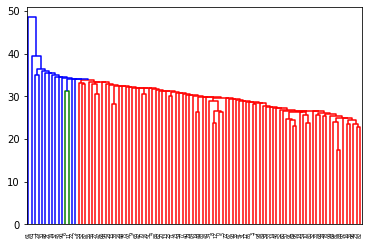

In [91]:
Z = hcluster.linkage(word_matrix)
plt.figure()
dn = hcluster.dendrogram(Z)
plt.show()

Мне хотелось посмотреть на граф, так как я никак не могла подобрать количество кластеров -- или 70, или 1

In [100]:
tree_clusters = hcluster.fclusterdata(word_matrix, 1.141)

In [101]:
tree_clusters

array([ 9,  1, 61, 10, 48,  9,  2, 10,  9, 52, 11,  2,  9, 44, 23,  5, 15,
       29, 11,  8, 45, 67, 62, 16, 13,  7, 56,  4, 57,  1, 69, 30, 19, 12,
        9, 32, 15, 65,  5, 25, 40, 31, 50, 36, 55, 64, 22,  4, 68,  8, 11,
       49, 21, 24, 11, 60,  4,  3,  3, 42, 20, 71, 46, 70, 14, 51, 59, 34,
       12, 11,  6,  7, 35, 43, 66, 54,  6, 41, 13, 39, 11, 14, 16, 37, 38,
       28, 47,  3, 14, 26, 63, 11, 17, 33, 58, 11, 16, 53, 27, 18],
      dtype=int32)

Почему t = 1.141? Если я возьму t на тысячную больше, то всё сольётся в один кластер, а это неинформативно. Если я возьму слишком маленькую t, то кластеров будет ещё больше, чем 71, а 71 -- это уже много

In [70]:
from collections import Counter

In [84]:
list_of_clusters = list(tree_clusters)
#Counter(list_of_clusters) #Раскомментируйте эту строку, чтобы посмотреть на словарь

По словарю  выше (его вывод длиннный, поэтому закомментирован) я поняла, что кластеров 71 и что большая их часть меньше трёх.

In [115]:
 from sklearn.cluster import KMeans
 from sklearn.metrics.pairwise import cosine_similarity
 
kmeans_clusters = KMeans(n_clusters=6).fit(word_matrix)
kmeans.labels_

array([2, 3, 3, 2, 0, 2, 0, 2, 2, 0, 1, 0, 2, 4, 5, 5, 4, 1, 1, 0, 5, 5,
       5, 5, 1, 2, 5, 5, 5, 3, 4, 2, 5, 4, 2, 4, 5, 5, 5, 1, 5, 3, 2, 5,
       0, 4, 1, 5, 4, 0, 1, 0, 1, 2, 1, 2, 5, 3, 3, 0, 1, 5, 0, 0, 3, 5,
       0, 5, 4, 1, 4, 2, 4, 5, 5, 5, 4, 1, 1, 5, 1, 3, 3, 5, 5, 2, 5, 3,
       3, 2, 0, 1, 3, 5, 5, 1, 2, 0, 2, 0], dtype=int32)

Почему кластеров 6? Я искала их оптимальное число, учитывая то, как они раскластеризовались в дереве. Сейчас там шесть кластеров с тремя и больше единицами в каждом.

### Ближайшие и центры

In [99]:
def get_dict(clusters, list_of_words, all_vectors_list):
    dict_of_clusters = {}
    for i, number_of_vector in enumerate(clusters):
        if number_of_vector not in dict_of_clusters:
            dict_of_clusters[number_of_vector] = [(list_of_words[i], all_vectors_list[i], i)]
        else:
            dict_of_clusters[number_of_vector].append((list_of_words[i], all_vectors_list[i], i))

    return dict_of_clusters

In [105]:
def get_centers(dict_of_clusters):
    centers = {}
    for cluster, vectors in dict_of_clusters.items():
        if len(vectors) > 2:
            matrix_of_vectors = np.array([el[1] for el in dict_of_clusters[cluster]])
            centers[cluster] = np.mean(matrix_of_vectors, axis=0)
    return centers

In [110]:
#функция печатает 3 ближайших
def get_neighbors(centers, dict_of_clusters):
    for cluster in centers:
        cent = centers[cluster]
        neighbors = {}
        for data_of_words in dict_of_clusters[cluster]:
            vector = data_of_words[1].reshape(1, -1)
            cent = cent.reshape(1, -1)
            neighbors[data_of_words[0]] = float(cosine_similarity(cent, vector))
        neighbors = dict(sorted(neighbors.items(), key=lambda item: item[1], reverse=True))
        print(', '.join(list(neighbors.keys())[0:3]))

### Результаты

Мы написали несколько упрощающих обработку функций. Теперь посмотрим на то, что получилось

In [111]:
 tree_dict = get_dict(tree_clusters, list_of_words, all_vectors_list)
 tree_center = get_centers(tree_dict)
 get_neighbors(tree_center, tree_dict)

открыть_дверь_NOUN, открыть_калитка_NOUN, открыть_дверца_NOUN
открыть_чемодан_NOUN, открыть_ящик_NOUN, открыть_шкаф_NOUN
открыть_америка_NOUN, открыть_шлюз_NOUN, открыть_старик_NOUN
открыть_музей_NOUN, открыть_выставка_NOUN, открыть_памятник_NOUN
открыть_грудь_NOUN, открыть_рука_NOUN, открыть_голова_NOUN
открыть_мать_NOUN, открыть_отец_NOUN, открыть_мама_NOUN


In [116]:
kmeans_dict = get_dict(kmeans_clusters.labels_, list_of_words, all_vectors_list)
kmeans_center = get_centers(kmeans_dict)
get_neighbors(kmeans_center, kmeans_dict)

открыть_ящик_NOUN, открыть_шкаф_NOUN, открыть_багажник_NOUN
открыть_грудь_NOUN, открыть_глаз_NOUN, открыть_голова_NOUN
открыть_батарея_NOUN, открыть_пальба_NOUN, открыть_огонь_NOUN
открыть_мир_NOUN, открыть_истина_NOUN, открыть_общество_NOUN
открыть_америка_NOUN, открыть_отец_NOUN, открыть_мать_NOUN
открыть_музей_NOUN, открыть_представительство_NOUN, открыть_выставка_NOUN


Ура! У нас есть результат! Что можно о нём сказать? 

Ближайшие из кластеров дерева. Первые два -- прекрасны! Один про двери разных видов, второй про вместилища. Третий странноват. Четвёртый опять прекрасен. Пятый -- сделать открытыми части тела, хотя здесь могут быть и переносные смыслы. Шестой интересен, первое, что пришло мне в голову -- можно сказать "открой кому-то" в значении "открой входную дверь/домофон/что-то вроде этого". Но в этом случае (пока единственный, который приходит мне в голову) можно опустить то, что именно нужно открывать. Хотя, конечно, здесь может быть что-то другое в значениях.

Теперь ближайшие средние. Первый похож на второй из дерева, второй совпадает с пятым из дерева. Третий новый, и он тоже хорош -- всё о том, чтобы начать стрелять. Четвёртый похож на правду минимум первыми двумя сочетаниями: открыть мир и открыть истину -- внезапно осознать нечто новое. Пятый похож на шестой выше, а "открыть Америку", видимо, блуждает. Шестой про то же, что четвёртый -- начало использования и/или существования новых учреждений/объектов. 

В общем и целом -- получилось у двух алгоритмов похоже. Есть несколько отличающихся моментов, но здесь мы можем увидеть, что основные группы значений открыть -- либо устранить преграду вроде двери, либо сделать доступным вместилище, либо сделать доступным/получить какое-то новое знание, либо начать процесс (стрельбы, например), либо начать и сделать доступным для использования учреждения. Ещё более в общем -- здесь присутствует общий элемент "сделать доступным для использования некоторый объект, или пространство, или знание, или процесс"